In [1]:
import numpy as np

def rms(Y):
    RMS = np.sqrt(np.mean(np.abs(Y) ** 2))
    return RMS

# Example

In [27]:
Y = np.array([1, 2, 3, 4, 5])
result = rms(Y)
print(result)

3.3166247903554


# GetBaseLineRMS

In [2]:
from psychopy import visual, core, event, monitors
import numpy as np
import os
import sounddevice as sd
import soundfile as sf
import time

def rms(y):
    return np.sqrt(np.mean(np.abs(y) ** 2))

def get_baseline_rms(window, bwod):
    # Create a monitor specification
    monitor = monitors.Monitor('testMonitor', width=53.1, distance=60)

    # Set up the PsychoPy window
    win = visual.Window(size=(800, 600), units='pix', fullscr=False, color=(255, 255, 255), monitor=monitor)

    # Display the initial message
    message_large = visual.TextStim(win, text='Hola: Trata de no hacer ruido durante los próximos 5 segundos\n ya que nosotros medimos la amplitud del ruido de fondo', pos=(0, 50), color=(50, 50, 50), height=24)
    message_large.draw()
    win.flip()

    # Record audio
    fs = 22050
    duration = 5

    if os.name == 'posix' and 'Darwin' in os.uname():
        audio_info = sd.query_devices(sd.default.device, 'input')
        recorder = sd.InputStream(device=audio_info['device'], channels=1, samplerate=fs, dtype=np.int16)
    else:
        recorder = sd.rec(int(fs * duration), channels=1, dtype=np.int16)
        sd.wait()

    tmpfname = os.path.join(bwod, 'bkgrdnoise.wav')
    sf.write(tmpfname, recorder.flatten(), fs)

    # Read the recorded audio
    y, _ = sf.read(tmpfname)

    # Calculate the RMS value
    baseline_rms = rms(y)

    # Display the thank-you message
    win.color = (255, 255, 255)
    win.flip()
    message_small = visual.TextStim(win, text='Muchas gracias por tu cooperación\n La practica va a empezar ahora', pos=(0, 50), color=(50, 50, 50), height=36)
    message_small.draw()
    win.flip()

    time.sleep(5)

    win.close()

    return baseline_rms


# Example 

In [2]:
monitor = monitors.Monitor('testMonitor', width=53.1, distance=60)
window = visual.Window(size=(800, 600), units='pix', fullscr=False, color=(255, 255, 255), monitor=monitor)
bwod = r"C:\Users\arunps\OneDrive\Projects\Scripts\Python\MA Thesis"  # desired path
baseline_rms = get_baseline_rms(window, bwod)
print("Baseline RMS:", baseline_rms)
# Close the window after the experiment
window.close()

16.5820 	WARNING 	Couldn't measure a consistent frame rate!
  - Is your graphics card set to sync to vertical blank?
  - Are you running other processes on your computer?

18.5172 	WARNING 	Couldn't measure a consistent frame rate!
  - Is your graphics card set to sync to vertical blank?
  - Are you running other processes on your computer?

18.6333 	WARNING 	t of last frame was 116.28ms (=1/8)
23.3174 	WARNING 	t of last frame was 4684.12ms (=1/0)
23.3520 	WARNING 	t of last frame was 34.61ms (=1/28)
Baseline RMS: 0.0008621422679402739


# Formants

In [89]:
import numpy as np

# Initialize global variables as arrays
f1p, f2p, f3p = np.array([None]), np.array([None]), np.array([None])

def frmntsold(a, srat):
    global f1p, f2p, f3p

    const = srat / (2 * np.pi)
    rts = np.roots(a)
    k = 1
    save = np.zeros(len(a)-1)
    bandw = np.zeros(len(a)-1)

    for i in range(len(a)-1):
        re, im = np.real(rts[i]), np.imag(rts[i])
        formn = const * np.arctan2(im, re)  # Formant frequencies
        bw = -0.5 * const * np.log(np.abs(rts[i]))  # Formant bandwidth

        if 90 < formn < 4000 and bw < 500:
            save[k-1] = formn
            bandw[k-1] = bw
            k += 1

    ind = np.argsort(save)

    # Impose some formant continuity constraints
    leny = len(save)
    only2 = leny == 2

    in1 = np.where(np.abs(f1p - save) < 150)[0]
    in2 = np.where(np.abs(f2p - save) < 150)[0]

    if in1.size > 1:
        i1 = in1[1]
    else:
        i1 = in1.item() if in1.size == 1 else None

    if in2.size > 1:
        i2 = in2[1]
    else:
        i2 = in2.item() if in2.size == 1 else None

    if i1 is not None and i2 is not None:
        if i1 == i2:
            F1, F2 = save[0], save[1]
            F3 = f3p[0] if only2 else save[2]
        else:
            F1, F2 = save[i1], save[i2]
            F3 = f3p[0] if i2 + 1 > leny else save[i2 + 1]
    elif i1 is not None and i2 is None:
        F1, F2 = save[i1], save[i1 + 1]
        F3 = f3p[0] if i1 + 2 > leny else save[i1 + 2]
    else:
        F1, F2 = save[0], save[1]
        F3 = f3p[0] if only2 else save[2]

    if f1p[0] is None:
        if only2:
            F1, F2, F3 = 300, 1200, 3000
        elif np.abs(save[0] - save[1]) < 80:
            F1, F2, F3 = save[1], save[2], save[3] if leny > 3 else 3000
        elif leny == 4:
            F1, F2, F3 = save[1], save[2], save[3]
        else:
            F1, F2, F3 = save[0], save[1], 3000

    # Last check
    if np.abs(F2 - F3) < 50:
        F2, F3 = f2p[0], f3p[0]

    if np.abs(F2 - F1) < 50:
        F2, F3 = f2p[0], f3p[0]

    # Update global variables
    f1p[0], f2p[0], f3p[0] = F1, F2, F3

    return F1, F2, F3


In [2]:
def frmnts(a,Fs):
    const = Fs / (2*np.pi)
    rts = np.roots(a)
    save = []
    bandw = []
    for rt in rts:
        re, im = np.real(rt), np.imag(rt)
        formn = const * np.arctan2(im, re)
        bw = -0.5 * const * np.log(np.abs(rt))
        if 90 < formn < 4000 and bw < 500:
            save.append(formn)
            bandw.append(bw)
    # Sort formants by frequency
    y = sorted(save)
    return y[0], y[1], y[2]

In [99]:
frmnts(a,Fs)

(550.414850153239, 915.3797258926264, 2512.829592296694)

In [103]:
# Example usage
# Replace 'a' and 'srat' with your actual values

srat = 44100  # Replace with your sampling rate
F1, F2, F3 = frmnts(a, Fs)
print(f"F1: {F1}, F2: {F2}, F3: {F3}")


F1: 550.414850153239, F2: 915.3797258926264, F3: 2512.829592296694


In [3]:
buffer = []
def callback(indata, frames, time, status):
    if status:
        print(f"Error in callback: {status}")
    # Append the incoming audio data to the buffer
    buffer.append(indata.copy())

In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def onset_offset(infile, make_plot=False):
    # Read the sound
    y, fs = librosa.load(infile, mono=True)

    # High pass filter the sound
    y = librosa.effects.preemphasis(y)
    
    # Automatic noise level estimation (th_noise)
    dt = int(round(0.05 * fs))
    Ndt = int(len(y) / dt)
    noise_est = np.min(np.sqrt(np.mean(np.reshape(y[:dt * Ndt], (dt, Ndt))**2, axis=0)))
    th_noise = 6 * noise_est

    # Compute a characteristic signal (Yp)
    dt = int(round(0.01 * fs))  # minimum half wave distance
    yp = (y > th_noise).astype(int)
    yp = np.convolve(np.abs(yp), np.ones(dt), mode='same')
    yp[[0, -1]] = 0

    # Find onset and offset
    thp = dt / 50
    center = np.argmax(yp)
    onset = np.where(np.diff(yp[:center] > thp))[0][-1]
    offset = np.where(np.diff(yp[center:] > thp))[0][0] + center

    # Assign extreme timings if not identified
    if onset.size == 0:
        onset = 0
    if offset.size == 0:
        offset = len(y)

    # Refine the onset and offset
    th_onset = np.percentile(np.abs(y[onset:offset]), 99) / 5
    onset_high = np.where(np.abs(y[onset:offset]) > th_onset)[0][0] + onset
    offset_high = np.where(np.abs(y[onset:offset]) > th_onset)[0][-1] + onset

    # Find the optimal center (for 100 ms analysis window)
    dt = int(round(0.1 * fs))  # minimum half wave distance
    yp = np.convolve(np.abs(y), np.ones(dt), mode='same')
    center = np.argmax(yp)

    # Change to seconds
    onset /= fs
    offset /= fs
    onset_high /= fs
    offset_high /= fs
    center /= fs

    # Make plots if asked for
    if make_plot:
        plt.figure()
        plt.plot(np.arange(len(y)) / fs, y, 'k')
        plt.axvline(x=onset, color='g', linestyle='-', linewidth=2, label='Onset')
        plt.axvline(x=offset, color='g', linestyle='-', linewidth=2, label='Offset')
        plt.axvline(x=onset_high, color='r', linestyle='-', linewidth=2, label='Onset High')
        plt.axvline(x=offset_high, color='r', linestyle='-', linewidth=2, label='Offset High')
        plt.axvline(x=center, color='c', linestyle='-', linewidth=3, label='Center')
        plt.legend()
        plt.show()

    return onset, offset, onset_high, offset_high, center

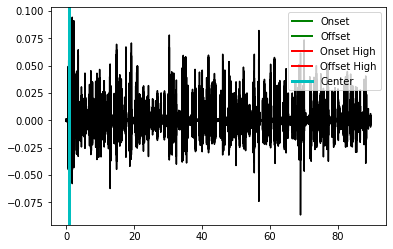

Onset: 0.6534240362811792, Offset: 0.7984580498866213, Onset High: 0.6563265306122449, Offset High: 0.7982766439909297, Center: 0.7278911564625851


In [6]:
# Example usage

infile = r'\\hypatia.uio.no\lh-hf-iln-sociocognitivelab\Research\BabyLearn\Working_dir\wav_files_organized\F_ADS_101_18.wav'
onset, offset, onset_high, offset_high, center = onset_offset(infile, make_plot=True)
print(f"Onset: {onset}, Offset: {offset}, Onset High: {onset_high}, Offset High: {offset_high}, Center: {center}")

In [5]:
import os
import sys
import numpy as np
import sounddevice as sd
import soundfile as sf
from psychopy import visual, core, event, sound, monitors
import random
from PIL import Image
import imageio
from scipy.signal import hamming, lfilter, resample
import librosa
import pdb
import pickle
import traceback
import datetime
import re

def runCond(nsubj, BlockNum, group, vowel, numRepetitions, numTokens, BWD, BWOD, fid,NPersistFB, TrimPortion, HamWind, RecordDuration, ScreenSize, whichScreen, window, FeedbackAxes, FeedbackScale, RMS, RMSIncrement, condition_number, block_number, FBRadius, DEBUG):
    persistent_feedback = np.empty((0, 2))
    PFBVALID = 1
    WarnTextCol = [175, 175, 175]
    PFB_Col = np.column_stack([np.linspace(225, 175, NPersistFB)] * 3)
    #fs = 11000
    #duration = RecordDuration
    #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=(255, 255, 255))

    #if os.name == 'posix' or ('Darwin' in os.uname()):
        #audio_info = sd.query_devices(sd.default.device, 'input')
        #recorder = sd.InputStream(device=audio_info['device'], channels=1, samplerate=fs, dtype=np.int16)
    #else:
        #recorder = sd.rec(int(fs * duration), channels=1, dtype=np.int16)
        #sd.wait()


    trial_counter = 0
    for rep in range(1, numRepetitions + 1):
        token_order = list(range(1, numTokens + 1))
        random.shuffle(token_order)  # Randomize the token sequence each time
        try:
            for i in token_order:
                trial_counter += 1
                print(f'trial_counter:{trial_counter}')
                # Drawing the target
                stimulus = vowel % (group, i)  # Stimulus is defined using formatted string
                print(f'stimulus:{stimulus}')
                

                if trial_counter == 1:
                    # LOAD THE BACKGROUND IMAGE:
                    #target_image_path = 'tokens.jpg'
                    # LOAD THE BACKGROUND IMAGE:

                    imageid = re.search(r'(.*_\w)\d*', stimulus).group(1)
                    print(f'imageid:{imageid}')
                    targetim = Image.open(os.path.join(BWD, f"{imageid}_tokens.jpg"))
                    targetim = np.array(targetim)
                    targetim = targetim / np.max(targetim)
                    originaltargetim=targetim
                    #sort out the image size for scaling and such
                    TargetImageSize = np.shape(targetim)
                    #what do we do to scale this properly? We have a screen
                    #size, and we will scale to the maximum dimension.
                    maxScale = min(TargetImageSize[1] / (ScreenSize[2] - ScreenSize[0]), TargetImageSize[0] / (ScreenSize[3] - ScreenSize[1]))
                    FBRadius = round((1 / maxScale) * FBRadius)

                    # Estimate the future size of the image on the screen
                    #TargetImageScaledSize = np.floor(maxScale * TargetImageSize[::-1])

                    # Cast into centered coordinates
                    ImageDisplaySize = np.array([0, 0, ScreenSize[2] - ScreenSize[0], ScreenSize[3] - ScreenSize[1]])

                    # ImageSize is the original size of the image
                    ImageSize = TargetImageSize[:2]



                    #size_x = targetim.size[0]
                    #size_y = targetim.size[1]
                    #targetim.size = [size_x * 0.3, size_y * 0.5]
    
                else:
                    # If it is not the first trial of the block, we should display the previous trial's feedback (if a response was recorded)
                    targetim = targetim_with_one_FB

                # Otherwise, it's already filled, with feedback, etc.
                #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                w = visual.ImageStim(window, image=targetim)  # Assuming target_image_path is the path to your target image
                # Use the ImageDisplaySize values
                size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                w.size = [size_x, size_y]
                w.draw()
                window.flip()
                event.waitKeys(0.5)
                w.autoDraw = False
                #window.close()

                # Load and play the target sound
                sound_path = os.path.join(BWD, f"{stimulus}.wav")
                print(f'sound_path:{sound_path}')
                target_sound = sound.Sound(sound_path)
                target_sound.play()

                # Display countdown
                #w = visual.ImageStim(window, image=targetim)
                #w = visual.TextStim(window, text="", pos=(0, 0), color=(-1, -1, -1), height=50)
                #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                for count in reversed(range(1, 4)):
                    w = visual.ImageStim(window, image=targetim)
                    size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                    size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                    w.size = [size_x, size_y]
                    w.draw()
                    window.flip()
                    event.waitKeys(0.5)
                    w.autoDraw = False

                    w = visual.TextStim(window, text="", pos=(0, 0), color=(-1, -1, -1), height=50)
                    #size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                    #size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                    #w.size = [size_x, size_y]
                    w.text = str(count)
                    w.font_size = 50
                    w.draw()
                    window.flip()
                    event.waitKeys(0.5)
                    w.autoDraw = False

                #window.close()
                # Set up audio recording parameters
                fs = 11000
                duration = RecordDuration
                #recorder = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.int16)

                #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                # Visual feedback during recording
                #w = visual.ImageStim(window, image=targetim)
                #warn_text_col = [175, 175, 175]
                #targetim.draw()
                #window.flip()
                #event.waitKeys(2)
                w = visual.ImageStim(window, image=targetim)
                size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                w.size = [size_x, size_y]
                w.draw()
                window.flip()
                event.waitKeys(0.5)
                w.autoDraw = False

                w = visual.TextStim(window, text="!", pos=(0, 0), color=(-1, -1, -1), height=50)
                #w.draw()
                #window.flip()
                #event.waitKeys(RecordDuration)
                # Initialize an empty buffer to store the audio data
                #buffer = []

                # Start the audio stream with the callback function
                with sd.InputStream(callback=callback, channels=1, samplerate=fs):
                     w.draw()
                     window.flip()
                     event.waitKeys(RecordDuration)
                     w.autoDraw = False

                     # Keep the program running for the specified duration
                     sd.sleep(int(duration * 1000))

                    # Concatenate the chunks in the buffer to get the full recording
                y = np.concatenate(buffer, axis=0)
                buffer.clear()

                # Save the full recording to a WAV file
                # Save the recorded audio to a WAV file
                out_wav = os.path.join(BWOD, f'Block_{block_number}_Condition_{condition_number}_{trial_counter:03}_{stimulus}_Repetition{rep:03}.wav')
                sf.write(out_wav, y, fs, subtype='PCM_16')

                #print("Recording saved as full_recording.wav")

                #sd.wait()
                #y = recorder.flatten()
                # Close PsychoPy window
                #window.close()

                
                if DEBUG == 2:
                    # Assuming 'stimulus' contains the filename without extension
                    filename = os.path.join(BWD, stimulus + '.wav')
                    recording, Fs = sf.read(filename, always_2d=True)
                    bits = recording.dtype.itemsize * 8
                    #RMS = 0.001
                else:
                    recording, Fs = sf.read(out_wav, always_2d=True)
                    bits = recording.dtype.itemsize * 8
                
                # Check RMS
                CheckRMS = rms(recording)
                print(f'CheckRMS:{CheckRMS}')
                core.wait(0.7)
                start_time, offset, onset_high, end_time, center = onset_offset(out_wav, 0)
                print(f'start_time:{start_time}, end_time:{end_time}, center{center}')
                if end_time-start_time <= 0.05:
                    print(f'duration:{end_time-start_time}')
                    CheckRMS = RMSIncrement*RMS

                if CheckRMS<=(RMSIncrement*RMS):
                    print('RMS is less than thershold value')
                    # if it wasn't loud enough, request louder response
                    #we redraw the screen incorporating only the previous
                    #production, and no new one
                    #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                    w = visual.ImageStim(window, image=targetim)
                    size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                    size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                    w.size = [size_x, size_y]
                    w.draw()
                    window.flip()
                    w.autoDraw = False
                    warning_text = 'No response was recorded.\n Please speak louder and longer when the "!" appears'
                    w = visual.TextStim(window, text=warning_text , pos=(0, 0), color=WarnTextCol, height=32)
                    w.draw()
                    window.flip()
                    event.waitKeys(3)
                    w.autoDraw = False
                    #output a null line
                    with open(fid, 'a') as file:
                        # Create a string in Python format
                        format_str = "{}\t{}\t{}\t{}\t{}\tNaN\tNaN\tNaN\tNaN\tNaN\tNaN\tNaN\tNaN\tNaN"

                        # Format the string with actual values
                        formatted_line = format_str.format(BlockNum, trial_counter, stimulus, rep, i)

                        # Write the formatted line to the file
                        file.write(formatted_line + '\n')
                    #We basically need to reset this for display purposes, the
                    #image that is written should be empty of feedback (since
                    #there wasn't any) and the image stored for next
                    #presentation should be feedback free as well
                    targetim =originaltargetim
                    file_name = f'Block_{block_number}_Condition_{condition_number}_{trial_counter}_{stimulus}_Repetition{rep}.jpg'
                    file_path = os.path.join(BWOD, file_name)
                    print('file_path:{file_path}')
                    # Save the image
                    #image = Image.fromarray(targetim)
                    imageio.imwrite(file_path,(targetim*255).astype(np.uint8))
                    targetim_with_one_FB=targetim
                    if NPersistFB > 1:
                        if persistent_feedback.shape[0] < NPersistFB:
                            persistent_feedback = np.vstack([persistent_feedback, [round(ScreenSize[0] / 2), round(ScreenSize[1] / 2)]])
                        else:
                            persistent_feedback = np.vstack([persistent_feedback[NPersistFB - 1:NPersistFB, :], [round(ScreenSize[0] / 2), round(ScreenSize[1] / 2)]])
                    else:
                        persistent_feedback = np.array([[round(ScreenSize[0] / 2), round(ScreenSize[1] / 2)]])
                    
                    PFBVALID=0
                    #window.close()
                else:
                    #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                    w = visual.ImageStim(window, image=targetim)
                    size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                    size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                    w.size = [size_x, size_y]
                    w.draw()
                    window.flip()
                    w.autoDraw = False
                    #window.close()
                    # Cut the recording to the middle portion
                    part_rec = recording[int(Fs * start_time):int(Fs * end_time)]
                    if DEBUG !=2:
                        part_rec = part_rec[int(Fs * TrimPortion[0]):int(len(part_rec) - Fs * TrimPortion[1])]
                    n_samples = len(part_rec)
                    Ncoeffs = int(2 + Fs / 1000) #11

                    # F0 estimate
                    son = hamming(n_samples) * part_rec
                    cn1 = lfilter([1], [1, 0.63], son)
                    LF = int(np.floor(Fs / 500))
                    HF = int(np.floor(Fs / 70))
                    cn = cn1[LF:HF]
                    ind = np.argmax(cn)
                    mx_cep = cn.flatten()[ind]
                    f0 = Fs / (LF + ind)

                    if f0 >= 350:
                        f0 = 200
                    
                    #formants=np.zeros((3,1))

                    #------Grab the middle portion and analyse it

                    df = int(0.05*Fs)
                    if len(part_rec) < 2200: # if the length of the cut portion is less than 200 ms, then take 20 ms segment
                        df = int(0.01*Fs)

                    if len(part_rec) < 550:
                        df = int(0.005*Fs)
                    
                    end_index = len(part_rec) // 2
                    sound1 = part_rec[end_index - df : end_index + df + 1]
                    sound2 = sound1.flatten() * hamming(len(sound1))
                    preemph = [1, 0.63]
                    sound2 = lfilter([1], preemph, sound2)

                    # Calculate LPC coefficients
                    a= librosa.core.lpc(sound2, order= Ncoeffs)
                    f1mean, f2mean, f3mean = frmnts(a, Fs)

                    # check extreme values
                    if f1mean < 300:
                        f1mean=f2mean
                        f2mean=f3mean
                    if f2mean < 1500:
                        f2mean=f3mean
                        f3mean=None
                    
                    #scaling
                
                    F1_F0=f1mean-f0
                    F2_F0=f2mean-f0

                    with open(fid, 'a') as file:
                        format_str = "{}\t{}\t{}\t{}\t{}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}"

                        # Format the string with actual values
                        formatted_line = format_str.format(BlockNum, trial_counter, stimulus, rep, i, f0, f1mean, f2mean, f3mean, F1_F0, F2_F0, start_time, end_time, center)

                        # Write the formatted line to the file
                        file.write(formatted_line + '\n')
                    #reload the original image with no feedback
                    targetim=originaltargetim #This is inefficient but I think trying to store
                    #and repeatedly update the images is too complicated for now it
                    #may even be possible to make this save before updating with
                    #the feedback...
                    XPosition = round((F2_F0 - FeedbackScale[0, 0]) / (FeedbackScale[1, 0] - FeedbackScale[0, 0]) * ImageSize[1])
                    # NOTICE THAT: order of subtraction is flipped because the axis is backwards, i.e., 6 is at the bottom, -1 is at the top
                    YPosition = ImageSize[0] - round((F1_F0 - FeedbackScale[0, 1]) / (FeedbackScale[1, 1] - FeedbackScale[0, 1]) * ImageSize[0])

                    #CATCH if positions are -ve (because this will crash) or
                    #out of range because this will also crash
                    if any([XPosition < (1 + FBRadius), XPosition > (ImageSize[1] - FBRadius), YPosition > (ImageSize[0] - FBRadius)]):
                        # So, for the case where feedback is out-of-range...
                        # find out which it is
                        if XPosition <= 0 + FBRadius:
                            XPosition = 1 + FBRadius
                        if YPosition <= 0 + FBRadius:
                            YPosition = 1 + FBRadius
                        if XPosition >= (ImageSize[1] - FBRadius):
                            XPosition = (ImageSize[1] - (1 + FBRadius))
                        if YPosition >= (ImageSize[0] - FBRadius):
                            YPosition = (ImageSize[0] - (1 + FBRadius))
                    # Assuming YPosition, XPosition, and FBRadius are floats or other numeric types
                    YPosition = int(YPosition)
                    XPosition = int(XPosition)
                    FBRadius = int(FBRadius)

                    # Now you can use these variables in your slicing operations
                    targetim[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, 0] = 0
                    targetim[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, 1] = 175
                    targetim[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, 2] = 255
                    targetim_with_one_FB=targetim
                    print(targetim_with_one_FB[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, 0])
                    print(targetim_with_one_FB[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, 1])
                    print(targetim_with_one_FB[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, 2])

                    # Define the filename using the provided format
                    filename = f"Block_{block_number}_Condition_{condition_number}_{trial_counter}_{stimulus}_Repetition{rep}.jpg"

                    # Save the image to the specified path
                    file_path = os.path.join(BWOD, filename)
                    #image = Image.fromarray(targetim)
                    imageio.imwrite(file_path,(targetim).astype(np.uint8))
                    for rgb in range(3):
                        targetim[YPosition - FBRadius:YPosition + FBRadius, XPosition - FBRadius:XPosition + FBRadius, rgb] = PFB_Col[-1][rgb]
                    
                    # Fill in the persistent feedback
                    if persistent_feedback.shape[0] != 0:
                        for PFB in range(persistent_feedback.shape[0]):
                        # Next check if the previous trial contained a valid response
                            if PFB == persistent_feedback.shape[0] - 1 and PFBVALID == 1:
                                # Adjust indices according to Python's zero-based indexing
                                targetim[
                                    int(persistent_feedback[PFB, 0] - FBRadius) : int(persistent_feedback[PFB, 0] + FBRadius + 1),
                                    int(persistent_feedback[PFB, 1] - FBRadius) : int(persistent_feedback[PFB, 1] + FBRadius + 1),
                                    :
                                    ] = PFB_Col[PFB, 0]
                    #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                    w = visual.ImageStim(window, image=targetim)
                    size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                    size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                    w.size = [size_x, size_y]
                    w.draw()
                    window.flip()
                    event.waitKeys(1.5)
                    w.autoDraw = False
                    #window.close()
                    # fill the array of persistent feedback values:
                    if NPersistFB > 1:
                        if persistent_feedback.shape[0] < NPersistFB:
                            persistent_feedback = np.vstack([persistent_feedback, [YPosition, XPosition]])
                        else:
                            persistent_feedback = np.vstack([persistent_feedback[NPersistFB - 1 : NPersistFB, :], [YPosition, XPosition]])
                    elif NPersistFB == 1:
                        persistent_feedback = np.array([[YPosition, XPosition]])
                    else:
                        # Handle the case when NPersistFB is less than or equal to 0
                        pass
                    PFBVALID = 1
                #window = visual.Window(size=(800, 800), units='pix', fullscr=False, color=WarnTextCol)
                w = visual.ImageStim(window, image=targetim)
                size_x = ImageDisplaySize[2] - ImageDisplaySize[0]
                size_y = ImageDisplaySize[3] - ImageDisplaySize[1]
                w.size = [size_x, size_y]
                w.draw()
                window.flip()
                w.autoDraw = False
                w = visual.TextStim(window, text='+' , pos=(0, 0), color=(-1, -1, -1), height=50)
                w.draw()
                window.flip()
                event.waitKeys(3)
                w.autoDraw = False
                #window.close()
        except Exception as e:
            traceback.print_exc()  

In [6]:
import os
from pathlib import Path
import numpy as np
from psychopy import visual, core, event
#from runCond import runCond

def training_eeg(nsubj, session, group, nblocks=5):
    '''
    this function requires the following input:
    subject number: any number
    session number: any number (but it will be 1,2, or 3
    group: 'H' or 'L'
    OPTIONAL INPUT: nblocks a number. I added this because you will want
    different numbers of blocks since the sessions will be of different
    lengths. It will default to 5 if no input is specified here.
    Calling the funciton is done as follows:
    expe(subjectnumber,sessionnumber,group,nblocks); e.g. expe(1,2,'H',8)
    For ease of calculation 1 block is 30 * 2 trials = 60 trials @
    approximately 5s each = 5 mins
    therefore in a 60minute session, you can set this to 11 or 12 Blocks
    '''
    DEBUG = 0 #If debug is set to 1 this ensures small screen for access to
    #python window, if debug is set to 2 this tests the lpc by feeding the
    #source vowel back into the mechanism and displaying its formants in the
    #space (this is a sanity to check to ensure that the lpc and display
    #scaling are correct)
    numRepetitions = 1 # Number of repetitions of each token within a block. Default is 1
    numTokens = 90 # Number of tokens per "condition" (condition is a VOWEL)
    conditions = ['A%s_a%d', 'E%s_e%d'] # these must be the filename prefixes
    NPersistFB = 1 # How many previous trials should be displayed?
    TrimPortion = [0.01, 0.01] # How much sound, in seconds, to cut off the front and back of the sound for analysis purposes
    ScreenScaleFactor = 1 # How much of the screen to use. Factors <1 will use proportion of screen, centred.
    HamWind = 1 # For example. The number of windows to use when calculating the LPC, 1 may be sufficient.
    RecordDuration = 1 #Specify the duration of the recording in seconds, here
    RMS = 0.001
    RMSIncrement = 1 #Specify a minimum volume level for the record, relative to a 5s recording of the background noise level carried out at the beginning of the experiment
    FeedBackRadius = 5 #How big should the feedback square be? 5 was the previous standard value. This is scaled later to take up the desired number of pixels
    #specify the scaling for the Bark transform
    FeedbackScale = np.array([[2600, 650], [600, 50]]) #The X-start Y-start; X-end Y-end co-ordinates, these axes([600 2600 50 650])were used to draw feedback image
    FeedbackAxes = np.abs(np.subtract(FeedbackScale[0], FeedbackScale[1]))
    #script_path = os.path.abspath(__file__)
    #basepath, _ = os.path.split(script_path)

    basepath = Path(os.path.realpath("")).as_posix()
    bwod = os.path.join(basepath, 'Results')
    BWD = os.path.join(basepath, 'Sources') #where are the sound files and the images?
    SUBJECT_DIR = os.path.join(bwod, f'Subject_{nsubj}')
    
    nsubj_str = str(nsubj)
    session_str = str(session)
    SUBJECT_DIR = os.path.join(bwod, f'Subject_{nsubj_str}')
    SESSION_DIR = os.path.join(SUBJECT_DIR, f'Session_{session_str}')

    # Create the SUBJECT_DIR and SESSION_DIR if they don't exist
    os.makedirs(SUBJECT_DIR, exist_ok=True)
    os.makedirs(SESSION_DIR, exist_ok=True)

    filename = f'Subject_{nsubj_str}_{group}_Session_{session_str}_Results.txt'
    fid = os.path.join(SESSION_DIR, filename)

    with open(fid, 'w') as file:
        file.write('BlockNumber\tTrialNumber\tVowelID\tInstance\tTokenNum\tF0\tF1\tF2\tF3\tF1_F0\tF2_F0\tOnset\tOffset\tCenter\n')
    
    # Set some parameters
    whichScreen = 0
    ScreenScaleFactor = 0.5 if DEBUG > 0 else 1.0

    # Get screen resolution
    
    mon = monitors.Monitor("testMonitor")  # Replace "testMonitor" with the actual monitor name
    mon.setWidth(34)  # adjust the width with the actual monitor width (in cm)

    # Get the screen resolution
    resolution = mon.getSizePix()
    xorig = round((resolution[0] - (ScreenScaleFactor * resolution[0])) * ScreenScaleFactor)
    yorig = round((resolution[1] - (ScreenScaleFactor * resolution[1])) * ScreenScaleFactor)
    ScreenSize = [xorig, yorig, xorig + (ScreenScaleFactor * resolution[0]), yorig + (ScreenScaleFactor * resolution[1])]
    # Set up psychopy window
    # Create a window
    window = visual.Window(size=(ScreenSize[2] - ScreenSize[0], ScreenSize[3] - ScreenSize[1]), units='pix', screen=whichScreen, fullscr=False, color=[255,255,255])
    # Get baseline RMS

    #RMS = get_baseline_rms(window, SESSION_DIR)

    # Display text
    #text = visual.TextStim(win, text='Hola: Tienes que repetir el sonido cuando el signo ! aparece', pos=(0, 0), color=[50, 50, 50], height=36)
    w = visual.TextStim(window, text='Hello: You have to repeat the sound when the sign ! appears' , pos=(0, 0), color=(-1, -1, -1), height=50)
    w.draw()
    window.flip()

    # Wait for 5 seconds
    event.waitKeys(5)

    # Close the window
    #window.close()

    for k in range(1, nblocks + 1):
        print(f'nblock:{k}')
        numbcond = np.random.permutation(len(conditions)) #generate random vowel order for every block
        print(f'condition:{numbcond}')
        #window2 = visual.Window(size=(ScreenSize[2] - ScreenSize[0], ScreenSize[3] - ScreenSize[1]), units='pix', fullscr=False, color=[255,255,255])
        # Set text size and draw text
        w = visual.TextStim(window, text='The beginning of the block', pos=(0, 0), color=(-1, -1, -1), height=32)
        w.draw()
        # Flip the window
        window.flip()
        # Wait for 2 seconds
        event.waitKeys(2)
        for v in numbcond:
            print(f'nvowel:{v}')
            vowel = conditions[v]
            runCond(nsubj, k, group, vowel, numRepetitions, numTokens, BWD, SESSION_DIR, fid,
                    NPersistFB, TrimPortion, HamWind, RecordDuration, ScreenSize, whichScreen, window, FeedbackAxes, FeedbackScale,
                    0.001, RMS, RMSIncrement, v, FeedBackRadius, DEBUG) #vowel must be the prefix in the filename

            # Display transition message
            w = visual.TextStim(window, text='Now we move on to the other vowel', pos=(0, 0), color=(-1, -1, -1), height=30)
            w.draw()
            window.flip()
            event.waitKeys(5)
            #window.close()
            for counter in range(5, -1, -1):
                w = visual.TextStim(window, text=str(counter), pos=(0, 0), color=(-1, -1, -1), height=36)
                w.draw()
                window.flip()
                event.waitKeys(1)
                #window.close()


        # Display pause message
        w = visual.TextStim(window, text='You can pause now\nPress the ENTER key to continue', pos=(0, 0), color=(-1, -1, -1), height=36)
        w.draw()
        window.flip()
        event.waitKeys(1)
        #window.close()

    # Display end of training message
    w = visual.TextStim(window, text='The training is over', pos=(0, 0), color=(-1, -1, -1), height=32)
    w.draw()
    window.flip()
    event.waitKeys(1)
    window.close()


In [7]:
nsubj = 1
session = 1
group = 'L'
nblocks = 1

In [8]:
training_eeg(nsubj, session, group, nblocks)

nblock:1
condition:[1 0]
nvowel:1
trial_counter:1
stimulus:EL_e89
imageid:EL_e
sound_path:C:/Users/arunps/OneDrive/Projects/Scripts/Python/MA Thesis\Sources\EL_e89.wav
CheckRMS:0.02666527891766775
start_time:0.9785487528344671, end_time:1.0300226757369615, center0.9861224489795918
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]]
[[255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 

Traceback (most recent call last):
  File "C:\Users\arunps\AppData\Local\Temp\ipykernel_27896\1349129137.py", line 199, in runCond
    start_time, offset, onset_high, end_time, center = onset_offset(out_wav, 0)
  File "C:\Users\arunps\AppData\Local\Temp\ipykernel_27896\3713716384.py", line 28, in onset_offset
    onset = np.where(np.diff(yp[:center] > thp))[0][-1]
IndexError: index -1 is out of bounds for axis 0 with size 0


nvowel:0
trial_counter:1
stimulus:AL_a90
imageid:AL_a
sound_path:C:/Users/arunps/OneDrive/Projects/Scripts/Python/MA Thesis\Sources\AL_a90.wav
CheckRMS:0.07228813011174551
start_time:0.9926530612244898, end_time:1.091156462585034, center1.0463945578231293
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]
 [175. 175. 175. 175. 175. 175. 175. 175.]]
[[255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255

Traceback (most recent call last):
  File "C:\Users\arunps\AppData\Local\Temp\ipykernel_27896\1349129137.py", line 199, in runCond
    start_time, offset, onset_high, end_time, center = onset_offset(out_wav, 0)
  File "C:\Users\arunps\AppData\Local\Temp\ipykernel_27896\3713716384.py", line 28, in onset_offset
    onset = np.where(np.diff(yp[:center] > thp))[0][-1]
IndexError: index -1 is out of bounds for axis 0 with size 0


41.3160 	WARNING 	Monitor specification not found. Creating a temporary one...
60.1801 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
60.1932 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
60.2722 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
60.4124 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
62.0012 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
62.0188 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
62.0377 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
62.0612 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
65.1275 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
65.1440 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
65.1628 	ERROR 	numpy arrays used as text

In [ ]:
import subprocess

def install_requirements(file_path):
    try:
        with open(file_path, 'r') as file:
            requirements = file.readlines()
            requirements = [req.strip() for req in requirements if req.strip() and not req.startswith('#')]
            
            if requirements:
                subprocess.run(['pip', 'install', *requirements])
                print("Packages installed successfully.")
            else:
                print("No packages to install from the requirements file.")

    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
requirements_file_path = 'requirements.txt'
install_requirements(requirements_file_path)
